In [108]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


In [109]:
url = "https://api.worldbank.org/v2/country/"
format = "json"
per_page = 50
def api_request_all_pages(url,date_start=None,date_end=None):
    result = []
    page = 1
    while True:
        params = {
            "source":2,
            "format": format,
            "per_page": per_page,
            "page": page
           
        }
        if date_start != None and date_end != None:
            params["date"]=f"{str(date_start)}:{str(date_end)}"
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        payload = response.json()
        total_pages = payload[0]["pages"]
        result += payload[1]

        if page < total_pages:
            page += 1
        else:
            break
    return result

countrys=["ESP","VEN","USA","ITA","RWA","ETH"]
url_with_countrys=url+";".join(countrys)
# payload=api_request_all_pages(url_with_countrys)
# payload

In [110]:
# Población total
# PIB per cápita (USD actuales) 
# Tasa de desempleo
# Esperanza de vida al nacer (años)   
indicators=["SP.POP.TOTL","NY.GDP.PCAP.CD","SL.UEM.TOTL.ZS","SP.DYN.LE00.IN"]
date_start=2010
date_end=2024
final_url = url_with_countrys+"/indicator/"+";".join(indicators)

countries_with_indicator = api_request_all_pages(final_url,date_start,date_end) 


In [111]:
def clean_indicator_df(df_row):
    df_row["indicator"]=df_row["indicator"]["id"]
    df_row["country"]=df_row["country"]["value"]
    df_row["date"]=int(df_row["date"])
    df_row["value"]=round(float(df_row["value"]),2)
    return df_row
    
df_countries_with_indicator=pd.DataFrame(countries_with_indicator)
df_countries_with_indicator=df_countries_with_indicator[["indicator","country","countryiso3code","date","value"]]
df_countries_with_indicator=df_countries_with_indicator.apply(clean_indicator_df,axis=1)
df_countries_with_indicator.columns=["Indicador","Pais","Pais(Iso3)","Año","Valor"]


df_population = df_countries_with_indicator[df_countries_with_indicator["Indicador"] == "SP.POP.TOTL"][["Pais","Pais(Iso3)", "Año", "Valor"]].dropna(axis=0)
df_population=df_population.rename(columns={"Valor":"Poblacion Total"})
df_PIB = df_countries_with_indicator[df_countries_with_indicator["Indicador"] == "NY.GDP.PCAP.CD"][["Pais","Pais(Iso3)", "Año", "Valor"]].dropna(axis=0)
df_PIB=df_PIB.rename(columns={"Valor":"PIB Per Capita"})
df_unemployment = df_countries_with_indicator[df_countries_with_indicator["Indicador"] == "SL.UEM.TOTL.ZS"][["Pais","Pais(Iso3)", "Año", "Valor"]].dropna(axis=0)
df_unemployment=df_unemployment.rename(columns={"Valor":"Tasa Desempleo"})
df_life_hope = df_countries_with_indicator[df_countries_with_indicator["Indicador"] == "SP.DYN.LE00.IN"][["Pais","Pais(Iso3)", "Año", "Valor"]].dropna(axis=0)
df_life_hope=df_life_hope.rename(columns={"Valor":"Esperanza De Vida"})

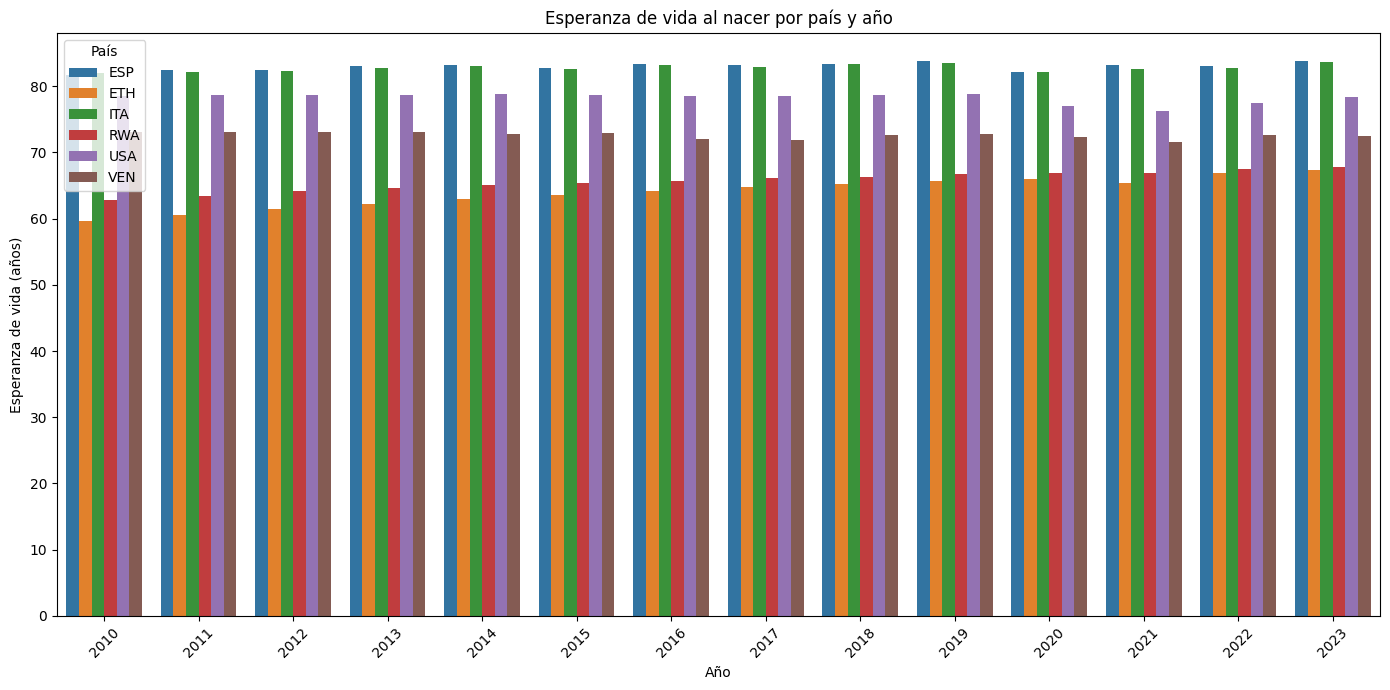

In [112]:
plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_life_hope,
    x="Año",
    y="Esperanza De Vida",
    hue="Pais(Iso3)", 
    palette="tab10"
)

plt.title("Esperanza de vida al nacer por país y año")
plt.xlabel("Año")
plt.ylabel("Esperanza de vida (años)")
plt.legend(title="País")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Descripcion del grafico:el grafico es uno de barras verticales representando la esperanza de vida de 6 paises a lo largo de los años 2010-2024(la api de https://api.worldbank.org/ por alguna razon no retorna el año 2024 para este indicador para el resto si).

Observaciones:
    1- A lo largo de los años que estamos evaluando no se observan cambios significativos entre mismos paises, esto de puede entender como relativa estabilidad(enfasis en relativa) mientras que en datos del siglo pasado quizas si se pudieran observar cambios mas evidentes entre los años.
    2- Paises desarrollados como España, Italia y estados unidos presentan una mejor esperanza de vida, paises como venezuela tiene una esperanza de vida relativamente alta pero con matizes, paises como Etiopía y Ruanda no tienen esperanzas de vida tan altas.

Nota:la calidad de los indicadores depende de la calidad (y honestidad) de las instituciones que los reportan y aunque el Banco Mundial, La ONU,La OMS,El FMI usan sus propios metodos de verificacion los gobiernos son la fuente primaria de muchos indicadores explicando porque paisen con un decenso economico y estructural a nivel de salud como venezuela se mantiene igual en numeros al pasar de los años.




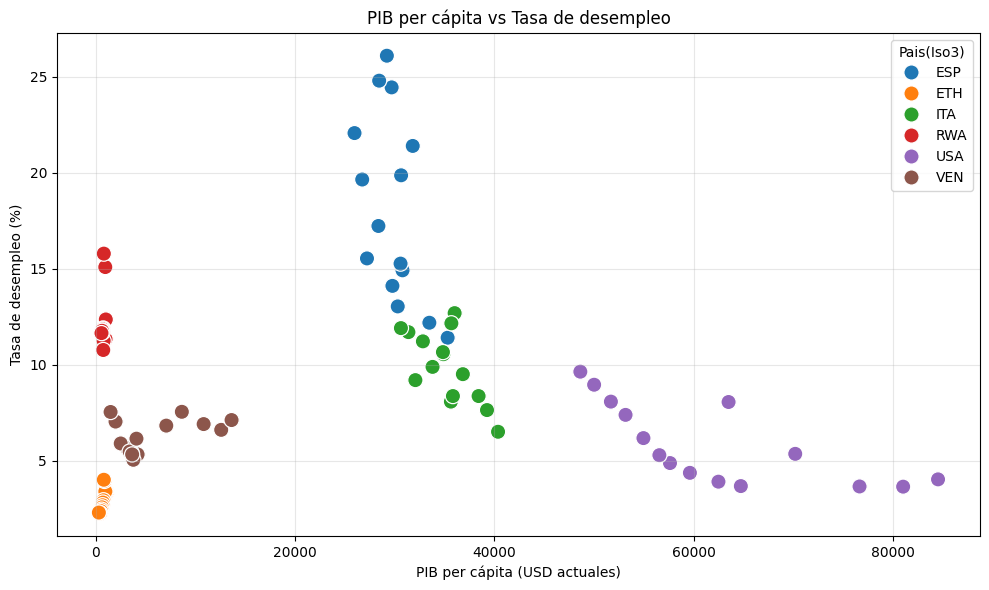

In [113]:
df_scatter = df_PIB.merge(df_unemployment, on=["Pais(Iso3)", "Año"], how="inner")
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_scatter,
    x="PIB Per Capita",
    y="Tasa Desempleo",
    hue="Pais(Iso3)",
    palette="tab10",
    s=120
)

plt.title("PIB per cápita vs Tasa de desempleo")
plt.xlabel("PIB per cápita (USD actuales)")
plt.ylabel("Tasa de desempleo (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Descripcion: el grafico es un scatterplot que muestra la relacion de dos indicadores "X" para PIB per capita y "Y" para la tasa de desempleo(%) cada pais es representado con su color y muestra cada uno 15 puntos tomando en cuenta que esta tomando datos de 2010-2024.

Observaciones:
 1- Estados unidos podemos decir que es lo típico de una economia desarrollada y estable alto PBI menos desempleo su rango va desde 49000-85000 aprox de PBI y una tasa de desempleo que no supera el 10% en su peor momento.

 2-  Con Italia tenemos un PIB medio-alto, y desempleo más alto que EEUU aunque encaja con la relacion.

 3- España es donde ya empezamos a ver que el patron no se cumple pues tiene un PBI similar a italia pero su desempleo ha alcanzado picos del 26% esto quiere decir que se ha visto afectado por otras variables que no son el PBI, no esta de mas agragar que se acopla a la crisis de empleo que tiene españa e los ultimos años.
 
4- Venezuela es otro caso atipico puesto que el PBI es muy bajo pero su tasa de desempleo se mantiene por debajo del 10%, como se explico en el primer grafico los datos no dependen 100% de los entes reguladores, sin embargo tambien se puede explicar como que las personas en venezuela en sus profeciones muchas veces cobraban en una moneda que no era oficial(dolar),entre muchas otras variables. 

5-Etiopía al igual que venezuela tienen un PBI muy bajo pero una tasa de desepleo sorprendentemente baja podria explicarse con que
gran parte de la población trabaja en agricultura informal o que el desempleo “oficial” no refleja subempleo real.

6-Ruanda a diferencia de etiopia tiene una tasa de desepleo mucho mas alta superando en ocasiones el 15% podriamos decir que algo de relacion tiene con el PBI pero hay otros indicadores que afectan en igual o mayor proporcion.



In [114]:
#creamos la base de datos y si ya existe la inicializa
conn = sqlite3.connect("world_bank_analysis.db")
#la query para crear la tabla
def create_table(name):
    query = f"""CREATE TABLE IF NOT EXISTS indicator_{name} (
        id INTEGER PRIMARY KEY,
        country TEXT,
        countryiso3code TEXT,
        year INTEGER,
        {name} DECIMAL
    );
    """
    #creamos un cursor para porder ejecutar las consultas, importante no mezclarlos entre consultas
    cur = conn.cursor()
    #ejecutamos y confimamos con commit
    cur.execute(query)
    conn.commit()
    #delete para que cada ves que se ejecute este codigo no haya nada en la tabla antes de hacer los inserts
    delete_query = f"""
    DELETE FROM indicator_{name} WHERE 1
    """
    cur = conn.cursor()
    cur.execute(delete_query)
    conn.commit()
    
create_table("population")
create_table("PIB")
create_table("unemployment")
create_table("life_hope")
  


In [115]:
cur = conn.cursor()
#leemos el dataframe con for e itertuples luego construimos un insert para cada tupla o fila acedemos a los valores por su index
def insert_table(name,df):
    for tupla in df.itertuples():
        query=f"""
        INSERT INTO indicator_{name} VALUES ({tupla[0]}, "{tupla[1]}", "{tupla[2]}", {tupla[3]}, {float(tupla[4])});
        """
        cur.execute(query)
    #ejecutamos el commit solo cuando finalice el for para no hacerlo cada vez que itere   
    conn.commit()
    #cerramos finalmente la conexion
    
    
insert_table("population",df_population)
insert_table("PIB",df_PIB)
insert_table("unemployment",df_unemployment)
insert_table("life_hope",df_life_hope)
conn.close()

In [116]:
#finalemte hacemos una consulta select normal para comprobar si se insertaron los datos bien
conn = sqlite3.connect("world_bank_analysis.db")
cur = conn.cursor()
query_test = """
SELECT * FROM indicator_population
""" 
result = cur.execute(query_test).fetchall()
print(result)
conn.close()

[(0, 'Spain', 'ESP', 2024, 48848840), (1, 'Spain', 'ESP', 2023, 48352528), (2, 'Spain', 'ESP', 2022, 47786102), (3, 'Spain', 'ESP', 2021, 47443821), (4, 'Spain', 'ESP', 2020, 47359424), (5, 'Spain', 'ESP', 2019, 47118501), (6, 'Spain', 'ESP', 2018, 46782011), (7, 'Spain', 'ESP', 2017, 46571232), (8, 'Spain', 'ESP', 2016, 46458139), (9, 'Spain', 'ESP', 2015, 46422303), (10, 'Spain', 'ESP', 2014, 46460733), (11, 'Spain', 'ESP', 2013, 46604197), (12, 'Spain', 'ESP', 2012, 46773055), (13, 'Spain', 'ESP', 2011, 46742697), (14, 'Spain', 'ESP', 2010, 46576897), (15, 'Ethiopia', 'ETH', 2024, 132059767), (16, 'Ethiopia', 'ETH', 2023, 128691692), (17, 'Ethiopia', 'ETH', 2022, 125384287), (18, 'Ethiopia', 'ETH', 2021, 122138588), (19, 'Ethiopia', 'ETH', 2020, 118917671), (20, 'Ethiopia', 'ETH', 2019, 115737383), (21, 'Ethiopia', 'ETH', 2018, 112664152), (22, 'Ethiopia', 'ETH', 2017, 109666481), (23, 'Ethiopia', 'ETH', 2016, 106718162), (24, 'Ethiopia', 'ETH', 2015, 103867135), (25, 'Ethiopia', 'E